**You will find here all the results related to the first approach in the Heston model.**

In [1]:
import numpy as np
import pandas as pd
# We import from assets all the parameters for the Heston model
from assets import N_Heston, S0, Neuler_Heston, T, K, a, kappa, sigma0, L_Tilde, r, G, weight_Heston
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

from model import DNN
from numpy.linalg import matrix_rank, inv
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from assets import f_Call_Basket, f_Put_Worst_Of, f_Digit_Basket, f_Asian_Arithmetic

In [2]:
summary = {'Number of assets' : N_Heston, '(Neuler, T)' : (Neuler_Heston, T), '(K, S0)' : (K, S0)}
summary

{'Number of assets': 10, '(Neuler, T)': (100, 1), '(K, S0)': (100, 100)}

In [3]:
nb_samples = int(1e5)
M_simulation = int(1e4)
sns.set(style="darkgrid")

In [4]:
def simulation(W, f, N):
    Z_simul = np.random.randn(M_simulation, N)
    y = f(Z_simul)

    U = W/ np.sqrt(np.sum(W * W, axis = 1)).reshape(-1,1)
    V = null_space(U).T
    M = np.concatenate((U,V), axis = 0)
    
    Z_simul = np.random.randn(M_simulation, N)
    Z_tilde = U@Z_simul.T
    n = Z_tilde.shape[0]
    tmp = np.concatenate((Z_tilde, np.zeros((N-n, M_simulation))))
    control_variate = f((inv(M)@tmp).T)
    control_variate_mean = np.mean(control_variate)
    Y_control = f(Z_simul) - control_variate + control_variate_mean
    return y, Y_control


def simulation_robust(W, f, N):
    Z_simul = np.random.randn(M_simulation, N)
    y = f(Z_simul)

    U = W/ np.sqrt(np.sum(W * W, axis = 1)).reshape(-1,1)
    V = null_space(U).T
    M = np.concatenate((U,V), axis = 0)
    
    Z_simul = np.random.randn(M_simulation, N)
    Z_tilde = U@Z_simul.T
    Z_tilde_ortho = V@Z_simul.T
    tmp = np.concatenate((Z_tilde, Z_tilde_ortho))
    control_variate = f((inv(M)@tmp).T)
    return np.mean(y), np.mean(control_variate)

In [5]:
def plot_simulation(y, Y_control, bins = [100,100, 100,100]):
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    plt.hist(y, bins = bins[0], label = 'mean = %.3f\nvar = %.5f'%(y.mean(), y.var()))
    plt.title('distribution of the initial_variable')
    plt.legend()
    plt.subplot(1,3,2)
    plt.hist(Y_control, bins = bins[1], label = 'mean = %.3f\nvar = %.5f'%(Y_control.mean(), Y_control.var()), color='orange')
    plt.title('distribution using control variate')
    plt.legend()
    plt.subplot(1,3,3)
    plt.hist(y, bins = bins[2], label = 'initial variable')
    plt.hist(Y_control,bins = bins[3], label = "control variate ", color='orange')
    plt.title('comparaison of distribution')
    plt.legend()
    plt.show()

# Basket Call Option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, 2 * N_Heston * Neuler_Heston)
f_Basket_Heston = lambda x: f_Call_Basket(x, a=a, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=S0, sigma=sigma0, T=T, weight=weight_Heston, is_Euler=True)
y = f_Basket_Heston(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_basket_heston = DNN(2 * N_Heston * Neuler_Heston, n=3)

In [ ]:
nnmodel_basket_heston.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 25)

# Save the model
filename = 'Basket_Heston.sav'
pickle.dump(nnmodel_basket_heston, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 4s 1ms/step - loss: 7.1848 - mse: 7.1848 - val_loss: 2.6486 - val_mse: 2.6486
Epoch 2/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 1.6506 - mse: 1.6506 - val_loss: 1.5042 - val_mse: 1.5042
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 1.2662 - mse: 1.2662 - val_loss: 1.0580 - val_mse: 1.0580
Epoch 4/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 1.0297 - mse: 1.0297 - val_loss: 0.9414 - val_mse: 0.9414
Epoch 5/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.9008 - mse: 0.9008 - val_loss: 0.7620 - val_mse: 0.7620
Epoch 6/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.7742 - mse: 0.7742 - val_loss: 1.3115 - val_mse: 1.3115
Epoch 7/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.7174 - mse: 0.7174 - val_loss: 0.6531 - val_mse: 0.6531
Epoch 8/1000
2500/2500 [========================

### 3. Test  and evaluation of the model
We evaluate our model using Mean Square Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = np.random.randn(M_simulation, 2 * N_Heston * Neuler_Heston)
y = f_Basket_Heston(Z)
y_pred = nnmodel_basket_heston.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 1s 852us/step
Monte Carlo price = 5.909. Control variate price = 5.866


0.3104227070760132

### 4. Simulation

In [ ]:
W = nnmodel_basket_heston.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Basket_Heston, 2 * N_Heston * Neuler_Heston)

True


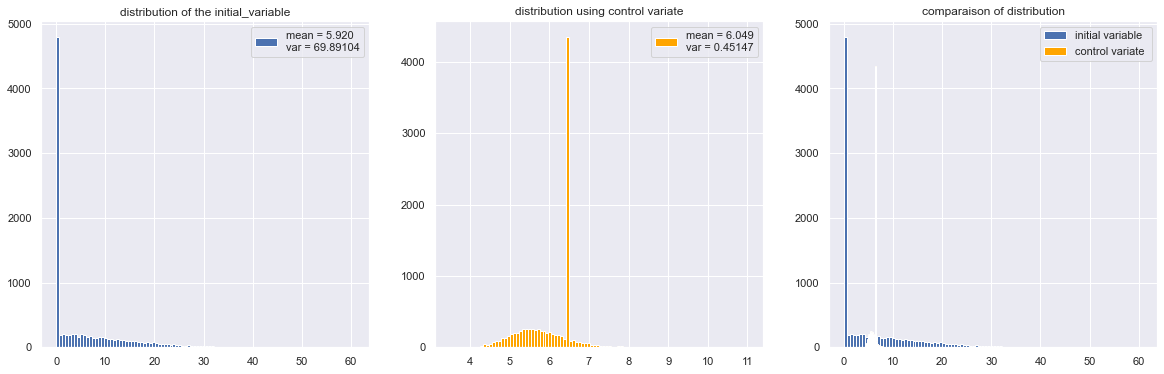

In [ ]:
plot_simulation(y, Y_control)

# Put  Worst-Of  Option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, 2 * N_Heston * Neuler_Heston)
f_PWO_Heston = lambda x: f_Put_Worst_Of(x, a=a, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=S0, sigma=sigma0, T=T, is_Euler=True)
y = f_PWO_Heston(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_PWO_Heston = DNN(2 * N_Heston * Neuler_Heston, n=3)

In [ ]:
nnmodel_PWO_Heston.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience=30)

# Save the model
filename = 'PWO_Heston.sav'
pickle.dump(nnmodel_PWO_Heston, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 6s 1ms/step - loss: 58.2780 - mse: 58.2780 - val_loss: 46.9451 - val_mse: 46.9451
Epoch 2/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 42.5531 - mse: 42.5531 - val_loss: 41.5165 - val_mse: 41.5165
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 41.4152 - mse: 41.4152 - val_loss: 41.6791 - val_mse: 41.6791
Epoch 4/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 40.5324 - mse: 40.5324 - val_loss: 41.2960 - val_mse: 41.2960
Epoch 5/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 40.0206 - mse: 40.0206 - val_loss: 41.3309 - val_mse: 41.3309
Epoch 6/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 39.3438 - mse: 39.3438 - val_loss: 40.9187 - val_mse: 40.9187
Epoch 7/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 38.7823 - mse: 38.7823 - val_loss: 40.1032 - val_mse: 40.1032
Epoch 8/1000
2500/25

### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, 2 * N_Heston * Neuler_Heston)
y = f_PWO_Heston(Z)
y_pred = nnmodel_PWO_Heston.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 1s 754us/step
Monte Carlo price = 21.59. Control variate price = 21.82


38.712542403780894

### 4. Simulation

In [ ]:
W = nnmodel_PWO_Heston.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_PWO_Heston, 2 * N_Heston * Neuler_Heston)

True


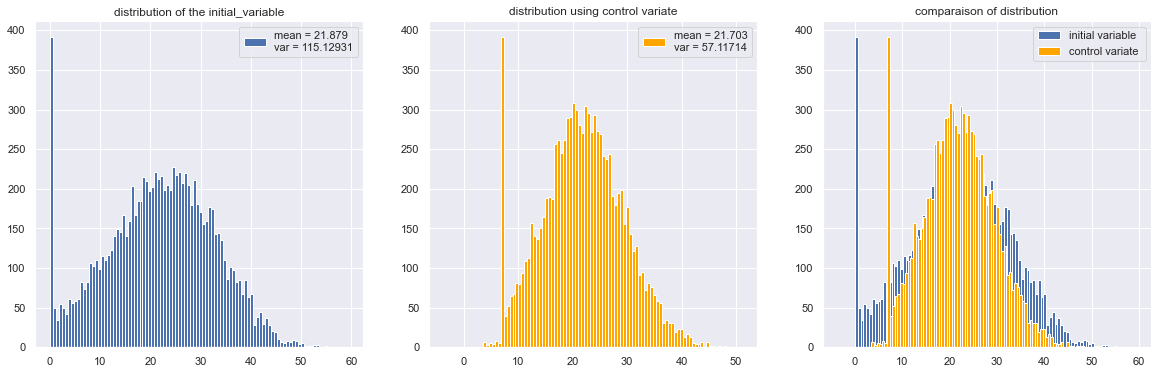

In [ ]:
plot_simulation(y, Y_control)

# Binary option (a digit) on the basket

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, 2 * N_Heston * Neuler_Heston)
f_Digit_Heston = lambda x: f_Digit_Basket(x, a=a, G=G, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=S0, sigma=sigma0, T=T, weight=weight_Heston, is_Euler=True)
y = f_Digit_Heston(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)
y_train = (y_train == 0).reshape(-1,1)
y_test = (y_test == 0).reshape(-1,1)

### 2. Model Creation
for this task we are using a binary classifier

In [ ]:
nnmodel_Digit_Heston = DNN(2 * N_Heston * Neuler_Heston, n=3, prediction_type="bin_class")

In [ ]:
nnmodel_Digit_Heston.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience=30)

# Save the model
filename = 'Digit_Heston.sav'
pickle.dump(nnmodel_Digit_Heston, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2379 - binary_accuracy: 0.8875 - val_loss: 0.1576 - val_binary_accuracy: 0.9298
Epoch 2/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1419 - binary_accuracy: 0.9373 - val_loss: 0.1243 - val_binary_accuracy: 0.9454
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1224 - binary_accuracy: 0.9463 - val_loss: 0.1153 - val_binary_accuracy: 0.9490
Epoch 4/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1109 - binary_accuracy: 0.9515 - val_loss: 0.1113 - val_binary_accuracy: 0.9504
Epoch 5/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1045 - binary_accuracy: 0.9549 - val_loss: 0.1038 - val_binary_accuracy: 0.9546
Epoch 6/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0984 - binary_accuracy: 0.9578 - val_loss: 0.1044 - val_binary_accuracy: 0.9550
Epoch 7/1000
2500/2500 [================

### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, 2 * N_Heston * Neuler_Heston)
y = f_Digit_Heston(Z)
y = (y==0)
y_pred = nnmodel_Digit_Heston.model.predict(Z)
y_pred = y_pred > 0.5
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
accuracy_score(y, y_pred)

313/313 [==============================] - 2s 704us/step
Monte Carlo price = 0.4573. Control variate price = 0.4535


0.9634

### 4. Simulation

In [ ]:
W = nnmodel_Digit_Heston.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Digit_Heston, 2 * N_Heston * Neuler_Heston)
y.var()/Y_control.var()

True


6.6248275505184955

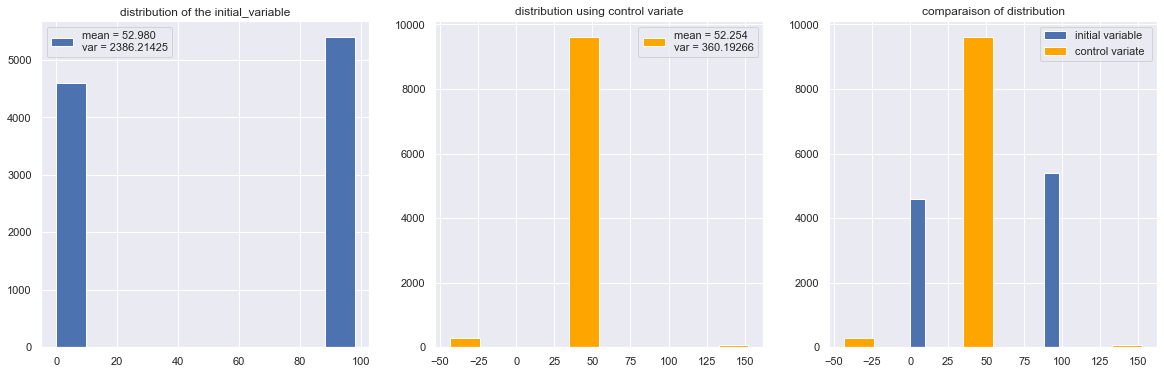

In [ ]:
plot_simulation(y, Y_control, bins = [10,10, 10, 10])

The variance of this method is very high because G = 100 and var(GZ) = G^2 * var(Z)

# Arithmetic asian option

### 1. Data generation

In [6]:
Z = np.random.randn(nb_samples, 2 * N_Heston * Neuler_Heston)
f_Asian_Heston = lambda x: f_Asian_Arithmetic(x, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=S0, sigma=sigma0, T=T, weight=weight_Heston)
y = f_Asian_Heston(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [7]:
nnmodel_Asian_Heston = DNN(2 * N_Heston * Neuler_Heston, n=3)

In [8]:
nnmodel_Asian_Heston.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 30)

# Save the model
filename = 'Asian_Heston.sav'
pickle.dump(nnmodel_Asian_Heston, open(filename, 'wb'))

Epoch 1/1000
2500/2500 [==============================] - 8s 2ms/step - loss: 2.2043 - mse: 2.2043 - val_loss: 0.4824 - val_mse: 0.4824
Epoch 2/1000
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4466 - mse: 0.4466 - val_loss: 0.3183 - val_mse: 0.3183
Epoch 3/1000
2500/2500 [==============================] - 7s 3ms/step - loss: 0.3354 - mse: 0.3354 - val_loss: 0.3435 - val_mse: 0.3435
Epoch 4/1000
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2822 - mse: 0.2822 - val_loss: 0.2350 - val_mse: 0.2350
Epoch 5/1000
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2294 - mse: 0.2294 - val_loss: 0.1990 - val_mse: 0.1990
Epoch 6/1000
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1955 - mse: 0.1955 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 7/1000
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1900 - mse: 0.1900 - val_loss: 0.1946 - val_mse: 0.1946
Epoch 8/1000
2500/2500 [====================

### 3. Test  and evaluation of the model

In [9]:
Z = np.random.randn(M_simulation, 2 * N_Heston * Neuler_Heston)
y = f_Asian_Heston(Z)
y_pred = nnmodel_Asian_Heston.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 1s 2ms/step
Monte Carlo price = 3.308. Control variate price = 3.444


0.1265337526285124

### 4. Simulation

True


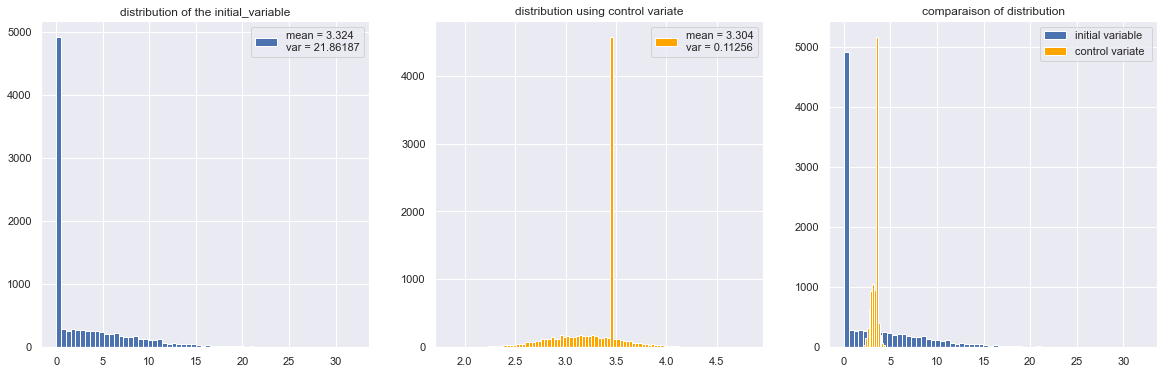

In [15]:
W = nnmodel_Asian_Heston.model.get_weights()[0].T
print(matrix_rank(W)==len(W)) # we check that our matrix has maximal rank
y, Y_control = simulation(W, f_Asian_Heston, 2 * N_Heston * Neuler_Heston)
plot_simulation(y, Y_control, ['auto', 'auto', 'auto', 15])

In [11]:
MC, CV = simulation_robust(W, f_Asian_Heston, 2 * N_Heston * Neuler_Heston)
print(MC, CV)

3.3565973936899187 3.249986719089586


### 5. Robustness

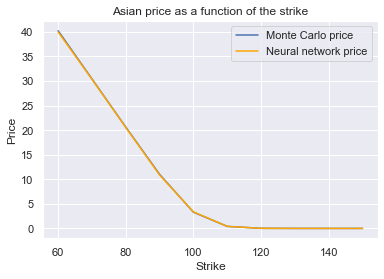

In [12]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, a=a, K=k*K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=S0, sigma=sigma0, T=T, weight=weight_Heston)
    y_MC[i], y_CV[i] = simulation_robust(W, f, 2 * N_Heston * Neuler_Heston)
plt.title('Asian price as a function of the strike')
plt.plot(k_list * K, y_MC, label = "Monte Carlo price")
plt.plot(k_list * K, y_CV, color='orange', label = "Neural network price")
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend()
plt.show()

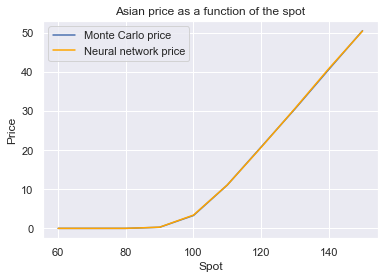

In [13]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, a=a, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=k*S0, sigma=sigma0, T=T, weight=weight_Heston)
    y_MC[i], y_CV[i] = simulation_robust(W, f, 2 * N_Heston * Neuler_Heston)
plt.title('Asian price as a function of the spot')
plt.plot(k_list * S0, y_MC, label = "Monte Carlo price")
plt.plot(k_list * S0, y_CV, color='orange', label = "Neural network price")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend()
plt.show()

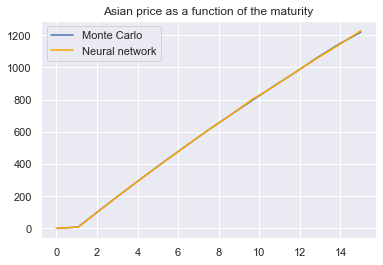

In [14]:
k_list = np.linspace(0, 15, 15)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, a=a, K=K, kappa=kappa, L=L_Tilde, model='Heston', Neuler=Neuler_Heston, r=r, S0=k*S0, sigma=sigma0, T=k*T, weight=weight_Heston)
    y_MC[i], y_CV[i] = simulation_robust(W, f, 2 * N_Heston * Neuler_Heston)
plt.title('Asian price as a function of the maturity')
plt.plot(k_list * T, y_MC, label = "Monte Carlo")
plt.plot(k_list * T, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()